## Pakiety

In [2]:
import pandas as pd
import numpy as np

from math import log
import category_encoders as ce

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Wczytnie zbioru

In [3]:
census_df = pd.read_csv('census_income_dataset.csv')
census_df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419.0,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
48838,64,?,321403.0,HS-grad,9,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K
48839,38,Private,374983.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
48840,44,Private,83891.0,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K


In [4]:
attributes_df = pd.read_csv('attributes_census_income.csv')

with pd.option_context('display.max_colwidth', 400):
    display(attributes_df)

,name,type,description
0,age,integer,age of individual
1,workclass,string,"Values: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked"
2,fnlwgt,float,Final sampling weight. Inverse of sampling fraction adjusted for non-response and over or under sampling of particular groups
3,education,string,"Values: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool"
4,education_num,integer,NaN
5,marital_status,string,"Values: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse"
6,occupation,string,"Values: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces"
7,relationship,string,"Values: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried"
8,race,string,"Values: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black"
9,sex,string,"Values: Female, Male"


## Inżynieria cech

#### Wartości brakujące i kolumny redundantne

Uznaliśmy, że wartości barkujących jest na tyle mało, że jest możliwe dokonanie usunięcia tych wierszy bez dużej straty próbki. Do finalnego modelowania może zostanie zastosowana imputacja.

In [5]:
census_df = census_df.replace(["?",-100000], np.nan)

In [6]:
census_df = census_df.dropna()

W wyniku EDA dokonanego wcześniej zdecydowaliśmy się na usunięcie kolumn "education" oraz "fnlwgt". Pierwsza z nich jest nadmiarowa, druga nie niesie szczególnego znaczenia dla dokonywania modelowania. 

In [7]:
census_df = census_df.drop(columns = ["education","fnlwgt"])

#### Kolumny "dwupunktowe"

Teraz pora na zero-jedynkowe zakodowanie zmiennych z kolumn "sex" oraz "income_level", gdyż wartości tam są tylko dwie.

In [8]:
census_df = census_df.replace("<=50K",0).replace(">50K",1)
census_df = census_df.replace("Male",1).replace("Female",0)

#### Modyfikacja education_num

Stwierdziliśmy jednak, że należy dokonać modyfikacji zawartości kolumny "education_num". Odległości między tymi liczbami mogą nie reprezentować faktycznego wpływu stopnia edukacji na wysokość zarobków

Poniższy kod wyświetli procent uzyskiwania wyższych zarobków dla danego "education_num" (w obrębie danej klasy). Widać że, im wyższy stopień edukacji, tym wyższy stosunek wysokich zarobków. Jednak wzrost ten nie jest liniowy.

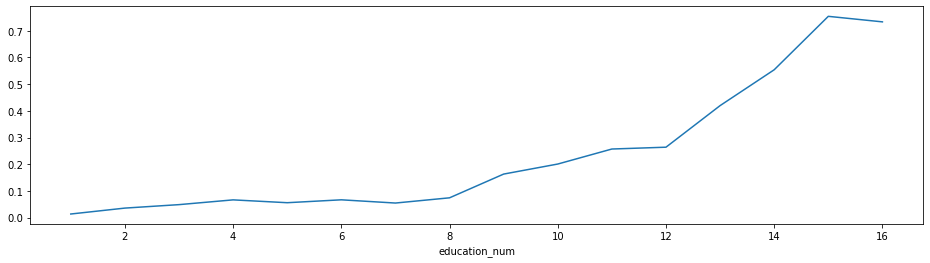

In [9]:
pd.DataFrame(census_df.groupby('education_num')["income_level"].value_counts(normalize=True).unstack('income_level'))[1].plot(figsize = (16, 4))
plt.show()

Dokonajmy zatem przekształcenia wartości w education_num funkcją 1.2^x, aby uzyskać odpowiednie przyrosty. 

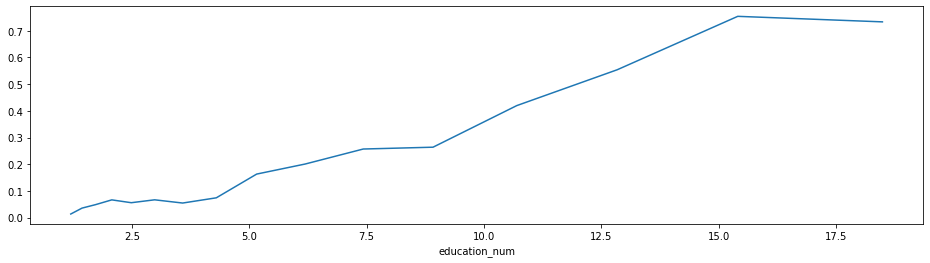

In [10]:
census_df['education_num'] = census_df['education_num'].apply(lambda x: 1.2 ** x)
pd.DataFrame(census_df.groupby('education_num')["income_level"].value_counts(normalize=True).unstack('income_level'))[1].plot(figsize = (16, 4))
plt.show()

#### Dwie dość skorelowane kolumny

In [11]:
census_df["marital_status"].value_counts()

Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: marital_status, dtype: int64

In [12]:
census_df["relationship"].value_counts()

Husband           18666
Not-in-family     11702
Own-child          6626
Unmarried          4788
Wife               2091
Other-relative     1349
Name: relationship, dtype: int64

Dwie powyższe kolumny są dosyć mocno skorelowane. Sugeruje to zarówno świadomość, jaką wartość one niosą jak i barploty sporządzone w EDA. Dokonajmy jednak głębszej analizy.

In [13]:
census_df[["marital_status", "relationship"]].value_counts()

marital_status         relationship  
Married-civ-spouse     Husband           18655
Never-married          Not-in-family      6691
                       Own-child          5864
Divorced               Not-in-family      3435
                       Unmarried          2267
Married-civ-spouse     Wife               2072
Never-married          Unmarried          1223
                       Other-relative      820
Widowed                Not-in-family       687
Separated              Unmarried           618
                       Not-in-family       588
Widowed                Unmarried           511
Divorced               Own-child           429
Married-spouse-absent  Not-in-family       282
Married-civ-spouse     Other-relative      184
Married-spouse-absent  Unmarried           169
Divorced               Other-relative      166
Separated              Own-child           130
Married-civ-spouse     Own-child           125
Separated              Other-relative       75
Widowed               

In [14]:
census_df_correl = census_df.replace('Wife', 'Married').replace('Husband', 'Married')
census_df_correl = census_df_correl.replace(['Married', 'Not-in-family', 'Own-child', 'Unmarried', 'Other-relative'], [0, 1, 2, 3, 4])
census_df_correl = census_df_correl.replace(['Married-civ-spouse', 'Never-married', 'Divorced', 'Widowed', 'Separated', 'Married-spouse-absent', 'Married-AF-spouse'], [0, 1, 2, 3, 4, 5, 6])

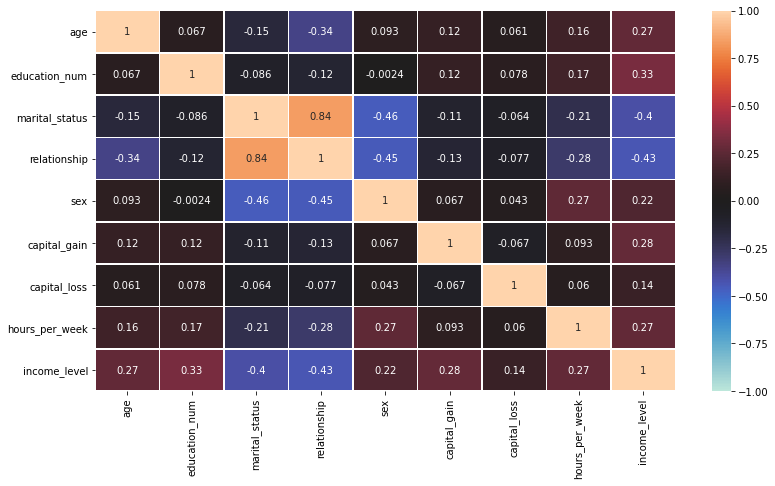

In [15]:
fig, ax = plt.subplots(figsize=(13,7)) 
sns.heatmap(census_df_correl.corr(method = "spearman"), linewidths=.5, center = 0, annot=True, vmin=-1)
plt.show()

Widzimy, że korelacja jest wysoka. Postanawiamy usunąc jedną z kolumn, wybieramy do tego marital_status. Występuje tam większe rozdrobnienie klas, o których lepsza informacja jest niesiona w kolumnie "relationship" 

In [16]:
census_df = census_df.drop(columns = "marital_status")

Co więcej, z EDA wynikał podobny rozkład zmiennej celu dla Husband oraz Wife, dlatego dokonamy zgrupowania tych wartości w ogólniejszą klasę Married.

In [17]:
census_df = census_df.replace('Wife', 'Married').replace('Husband', 'Married')

### Encoding

#### TargetEncoding dla Native_country

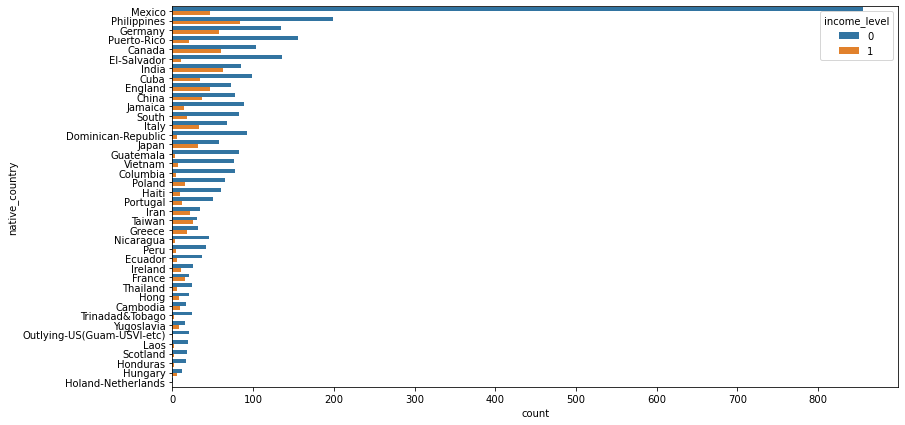

In [18]:
fig, ax = plt.subplots(figsize=(13,7))
df = census_df[census_df.native_country != "United-States"]
sns.countplot(y='native_country', hue='income_level', data=df,  order = df['native_country'].value_counts().index)
plt.show()

Powyższy wykres nie zawiera Stanów Zjednoczonych!! 
Z EDA wynikał dosyć rożny rokład zminnej celu dla różnych państw. Z tego powodu postanawiamy dokonać encodingu z użyciem TargetEncoding. Onehot generowałby zbyt dużo cech.

In [19]:
target_encoder = ce.TargetEncoder(cols=['native_country'])
census_df = target_encoder.fit_transform(census_df, census_df['income_level'])

#### OnehotEncoding

Dla poniższych klas zastosujemy OnehotEncoding.

In [20]:
census_df["workclass"].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: workclass, dtype: int64

In [21]:
census_df["race"].value_counts()

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64

In [22]:
census_df["occupation"].value_counts()

Craft-repair         6020
Prof-specialty       6008
Exec-managerial      5984
Adm-clerical         5540
Sales                5408
Other-service        4808
Machine-op-inspct    2970
Transport-moving     2316
Handlers-cleaners    2046
Farming-fishing      1480
Tech-support         1420
Protective-serv       976
Priv-house-serv       232
Armed-Forces           14
Name: occupation, dtype: int64

W przpadku occupation, wykorzystując dodatkowo wykresy z EDA, decydujemy się na pewne grupowanie. Klasa Armed-Forces jest wyjątkowo mało liczna, a klasa Priv-house-serv tylko nieco liczniejsza, ma dodatkowo podobny do Other-service rozkład; grupujemy do Other-service.

In [23]:
census_df = census_df.replace(["Priv-house-serv", "Armed-Forces"], "Other-service")

In [24]:
onehot_encoder = ce.OneHotEncoder(cols=['occupation','relationship','race', 'workclass'])
census_df = onehot_encoder.fit_transform(census_df, census_df['income_level'])
census_df

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,education_num,occupation_1,...,race_2,race_3,race_4,race_5,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,1,0,0,0,0,0,0,10.699321,1,...,0,0,0,0,1,2174.0,0.0,40.0,0.253027,0
1,50,0,1,0,0,0,0,0,10.699321,0,...,0,0,0,0,1,0.0,0.0,13.0,0.253027,0
2,38,0,0,1,0,0,0,0,5.159780,0,...,0,0,0,0,1,0.0,0.0,40.0,0.253027,0
3,53,0,0,1,0,0,0,0,3.583181,0,...,1,0,0,0,1,0.0,0.0,40.0,0.253027,0
4,28,0,0,1,0,0,0,0,10.699321,0,...,1,0,0,0,0,0.0,0.0,40.0,0.255639,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,0,0,1,0,0,0,0,10.699321,0,...,0,0,0,0,1,0.0,0.0,40.0,0.253027,0
48837,39,0,0,1,0,0,0,0,10.699321,0,...,0,0,0,0,0,0.0,0.0,36.0,0.253027,0
48839,38,0,0,1,0,0,0,0,10.699321,0,...,0,0,0,0,1,0.0,0.0,50.0,0.253027,0
48840,44,0,0,1,0,0,0,0,10.699321,1,...,0,1,0,0,1,5455.0,0.0,40.0,0.253027,0


#### Praca z capital gain/loss

Wprowadzamy jedną cechę zamiast dwóch zachowując infromację.

In [25]:
census_df["capital_diff"] = census_df["capital_gain"] - census_df["capital_loss"]
census_df = census_df.drop(columns = ["capital_gain", "capital_loss"])

#### Przeskalowanie wartości

Dokonujemy przeskalowania wartości numerycznych do przedziałow usatlonej wielkości, co może wpłynąć na poprawę działania części model.

In [26]:
census_df["capital_diff"] = census_df["capital_diff"] / max(abs(census_df["capital_diff"]))
census_df["education_num"] = census_df["education_num"] / max(abs(census_df["education_num"]))
census_df["hours_per_week"] = census_df["hours_per_week"] / max(abs(census_df["hours_per_week"]))
census_df["age"] = census_df["age"] / max(abs(census_df["age"]))

In [27]:
census_df

,age,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,education_num,occupation_1,...,race_1,race_2,race_3,race_4,race_5,sex,hours_per_week,native_country,income_level,capital_diff
0,0.433333,1,0,0,0,0,0,0,0.578704,1,...,1,0,0,0,0,1,0.404040,0.253027,0,0.021740
1,0.555556,0,1,0,0,0,0,0,0.578704,0,...,1,0,0,0,0,1,0.131313,0.253027,0,0.000000
2,0.422222,0,0,1,0,0,0,0,0.279082,0,...,1,0,0,0,0,1,0.404040,0.253027,0,0.000000
3,0.588889,0,0,1,0,0,0,0,0.193807,0,...,0,1,0,0,0,1,0.404040,0.253027,0,0.000000
4,0.311111,0,0,1,0,0,0,0,0.578704,0,...,0,1,0,0,0,0,0.404040,0.255639,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,0.366667,0,0,1,0,0,0,0,0.578704,0,...,1,0,0,0,0,1,0.404040,0.253027,0,0.000000
48837,0.433333,0,0,1,0,0,0,0,0.578704,0,...,1,0,0,0,0,0,0.363636,0.253027,0,0.000000
48839,0.422222,0,0,1,0,0,0,0,0.578704,0,...,1,0,0,0,0,1,0.505051,0.253027,0,0.000000
48840,0.488889,0,0,1,0,0,0,0,0.578704,1,...,0,0,1,0,0,1,0.404040,0.253027,0,0.054551


## Wstępne modelowanie

Stworzymy osiem początkowych modeli oraz  jeden model głosujący; będziemy kolejno badać ich accuracy.

In [28]:
y = np.array(census_df['income_level'])
X = census_df.drop(['income_level'], axis=1)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2137)

In [30]:
d = {}  # do słownika będziemy zapisywać uzyskane accuracy każdego modelu

### 1. Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(max_depth = 11, random_state = 0)

model_dt.fit(X_train, y_train)
sc_dt = model_dt.score(X_test, y_test)
d["Decision Tree"] = sc_dt
sc_dt

0.8570480928689884

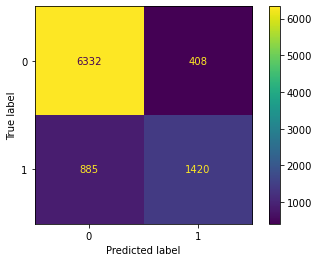

In [32]:
plot_confusion_matrix(model_dt, X_test, y_test)  
plt.show()

### 2. KNeighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier

model_kn = KNeighborsClassifier(n_neighbors = 4)

model_kn.fit(X_train, y_train)
sc_kn = model_kn.score(X_test, y_test)
d["KNeighbors"] = sc_kn
sc_kn

0.817910447761194

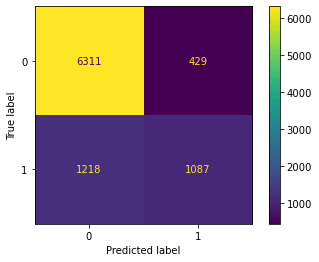

In [34]:
plot_confusion_matrix(model_kn, X_test, y_test)  
plt.show()

### 3. Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state = 1, max_iter = 1000)

model_lr.fit(X_train, y_train)
sc_lr = model_lr.score(X_test, y_test)
d["Logistic Regression"] = sc_lr
sc_lr

0.8416804864566059

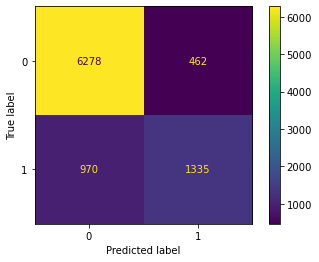

In [36]:
plot_confusion_matrix(model_lr, X_test, y_test)  
plt.show()  

### 4. SVC

In [37]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
sc_svm = svm.score(X_test, y_test)
d["SVC"] = sc_svm
sc_svm

0.8315091210613599

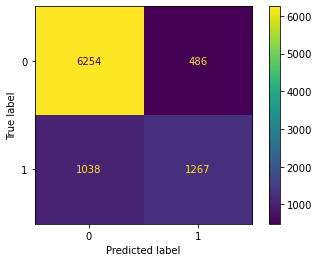

In [38]:
plot_confusion_matrix(svm, X_test, y_test)  
plt.show()  

### 5. Gaussian NB

In [39]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()

model_nb.fit(X_train, y_train)
sc_nb = model_nb.score(X_train, y_train)
d["Gaussian NB"] = sc_nb
sc_nb

0.7540149818945739

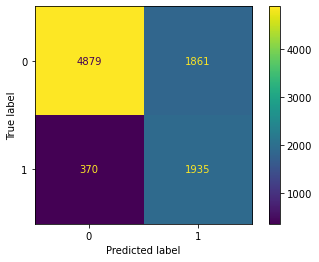

In [40]:
plot_confusion_matrix(model_nb, X_test, y_test)  
plt.show()

### 6. Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators = 400, max_depth = 7, min_samples_split = 2,
                                  max_features = 5, random_state = 0, n_jobs = -1)
model_rf.fit(X_train, y_train)
sc_rf = model_rf.score(X_test, y_test)
d["Random Forest"] = sc_rf
sc_rf

0.8487562189054726

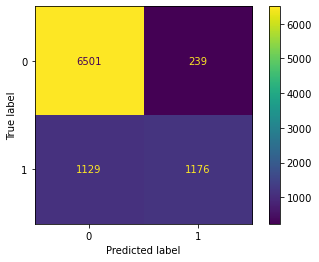

In [42]:
plot_confusion_matrix(model_rf, X_test, y_test)  
plt.show()

### 7. Ada Boost

In [43]:
from sklearn.ensemble import AdaBoostClassifier

model_ab = AdaBoostClassifier(random_state = 1, n_estimators = 20, learning_rate = 0.5)
model_ab.fit(X_train, y_train)
sc_ab = model_ab.score(X_test, y_test)
d["Ada Boost"] = sc_ab
sc_ab

0.851077943615257

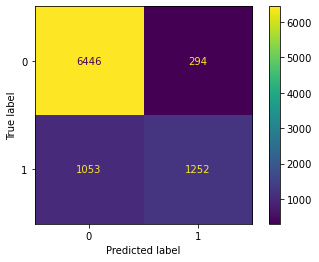

In [44]:
plot_confusion_matrix(model_ab, X_test, y_test)  
plt.show()

### 8. XGB

In [45]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(random_state = 1, learning_rate = 0.01, booster = 'gbtree',
                    nround = 200, max_depth = 7)
model_xgb.fit(X_train, y_train)
sc_xgb = model_xgb.score(X_test, y_test)
d["XGB"] = sc_xgb
sc_xgb

[13:44:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { nround } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8550580431177446

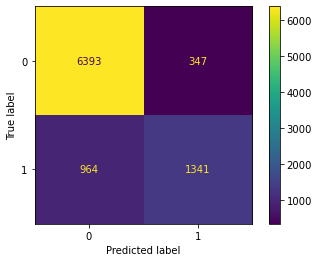

In [46]:
plot_confusion_matrix(model_xgb, X_test, y_test)  
plt.show()

Możemy stworzyć tabelę podsumowywującą accuracy wszystkich do tej pory modeli. Widzimy w ten sposób, które z nich są najlepsze.

In [47]:
df = pd.DataFrame(data = {"models" : d.keys(), "scores" : d.values()})
df.sort_values(by = "scores", ascending = False).reset_index(drop = True)

,models,scores
0,Decision Tree,0.857048
1,XGB,0.855058
2,Ada Boost,0.851078
3,Random Forest,0.848756
4,Logistic Regression,0.841680
5,SVC,0.831509
6,KNeighbors,0.817910
7,Gaussian NB,0.754015


Wybierzmy 5 najlepszych modeli i stwórzmy z nich model głosujący:

In [48]:
estimators = [('DecisionTree', model_dt), ('XGB', model_xgb), ('AdaBoost', model_ab),
              ('RF', model_rf), ('LR', model_lr)]

In [49]:
from sklearn.ensemble import VotingClassifier

model_soft = VotingClassifier(estimators = estimators, voting = 'soft')
model_soft.fit(X_train, y_train)
model_soft.score(X_test, y_test)

[13:44:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { nround } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.859812050856827

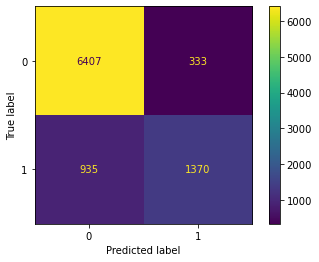

In [50]:
plot_confusion_matrix(model_soft, X_test, y_test)  
plt.show()

Nasz model głosujący osiągnął najwyższe accuracy spośród wszystkich naszych wstępnych modeli.

W finalnym modelowaniu, do oceny działania naszych modeli posłużymy się również innymi metrykami.
Użyjemy prawdopodobnie również crosswalidacji.